# Effects of Initial Condition in the GM Model

By keeping all paramters constant and domain consistent as a 40 X 40 square, we visualized the evolution of pattern with ADI method with 4 different initial conditions.

We chose to use ADI method to compute the solution for the PDE equations since it is comparatively the most accurate (2-nd order) and the most stable (allows the largest dt) among all the 4 methods we tried.

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

## Experiments Parameters Setup

### Varied Initial Conditions 
```python
# 1. U: random noise 1
U_init = np.random.normal(0.5, 1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))

# 2. U: random noise 2
U_init = np.random.normal(2, 0.1, (Ny, Nx)) 
V_init = 0.1 * np.ones((Ny, Nx))

# 3. U: a centered cluster of ones
U_init = np.zeros((Ny, Nx)) 
j_0 = int(2/5*Ny) 
j_1 = int(3/5*Ny)
k_0 = int(2/5*Nx)
k_1 = int(3/5*Nx)
U_init[j_0:j_1, k_0:k_1] = 1
V_init = 0.1 * np.ones((Ny, Nx))

# 4. U: 2 clusters of ones
U_init = np.zeros((Ny, Nx)) 
ja_0 = int(2/5*Ny) 
ja_1 = int(3/5*Ny)
ka_0 = int(3/5*Nx)
ka_1 = int(4/5*Nx)
jb_0 = int(3/5*Ny) 
jb_1 = int(4/5*Ny)
kb_0 = int(2/5*Nx)
kb_1 = int(3/5*Nx)
U_init[ja_0:ja_1, ka_0:ka_1] = 1
U_init[jb_0:jb_1, kb_0:kb_1] = 1
V_init = 0.1 * np.ones((Ny, Nx))

```
### Other Controled Conditions
```python
Ny, Nx = 40, 40 # length of the sides of the entire grid
h = 2 # space step size, same in x and y direction
N = Nx * Ny # 1D length of the entire grid

Du = 0.02 # diffusion rate of u
Dv = 2 # diffusion rate of v
rho = 0.001 # source density
rho_u = 0.001 # basic activator production rate
mu_u = 0.02 # decay rate of u
mu_v = 0.03 # decay rate of v
kappa = 0.1 # saturation constanct

dt = 20 # time step size for ADI
end_t = 10000 # end time
time_steps = int(end_t / dt) # number of time steps of the entire evolution
```

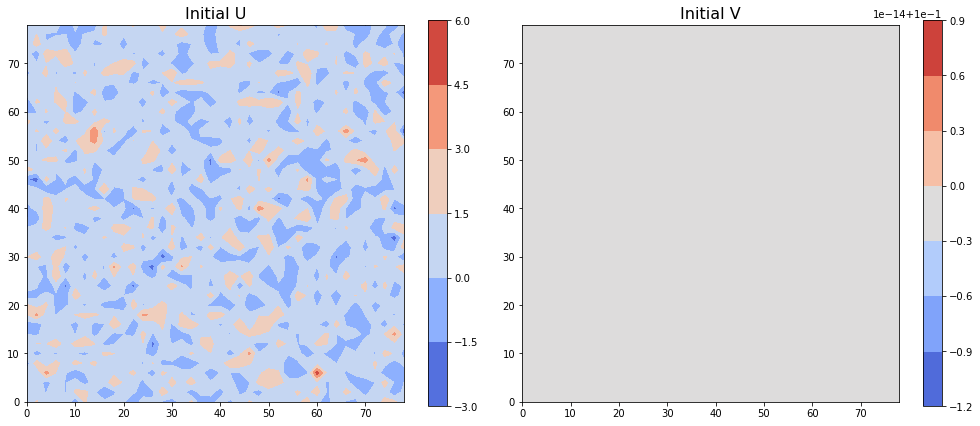

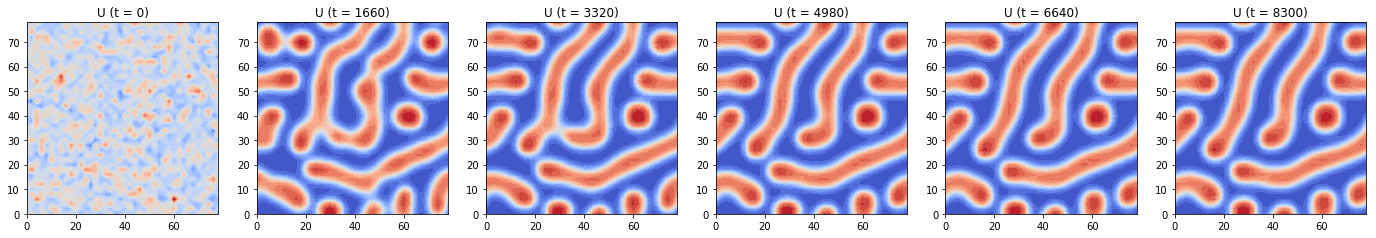

In [2]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Visualize Initial conditions --- U: random noise 1
U_init = np.random.normal(0.5, 1, (Ny, Nx))
V_init = 0.1 * np.ones((Ny, Nx))
plot_init(U_init, V_init, h, filled=True)

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
        + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
        + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)

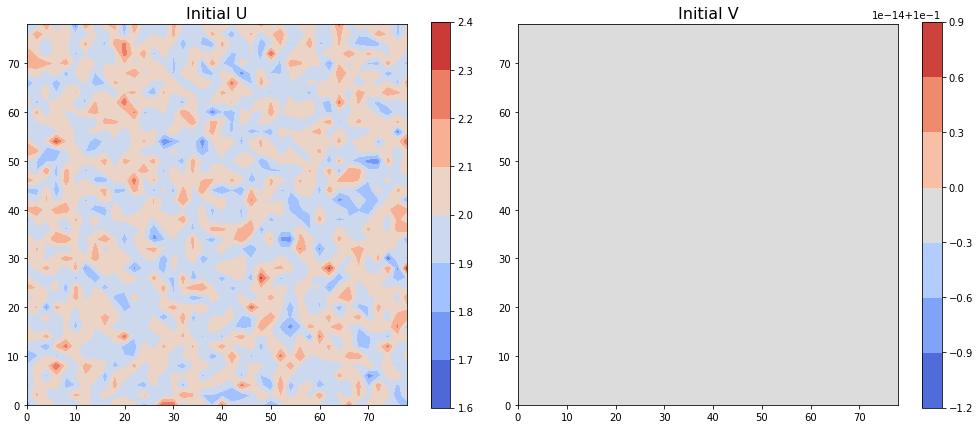

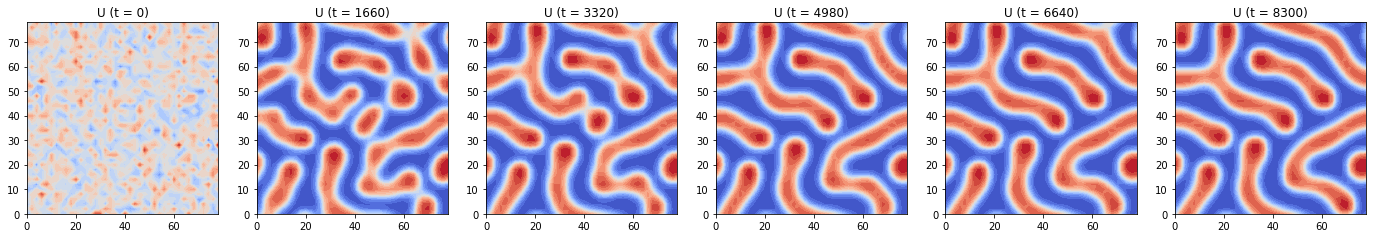

In [3]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Visualize initial conditions --- U: random noise 2
U_init = np.random.normal(2, 0.1, (Ny, Nx)) 
V_init = 0.1 * np.ones((Ny, Nx))
plot_init(U_init, V_init, h, filled=True)

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
        + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
        + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)

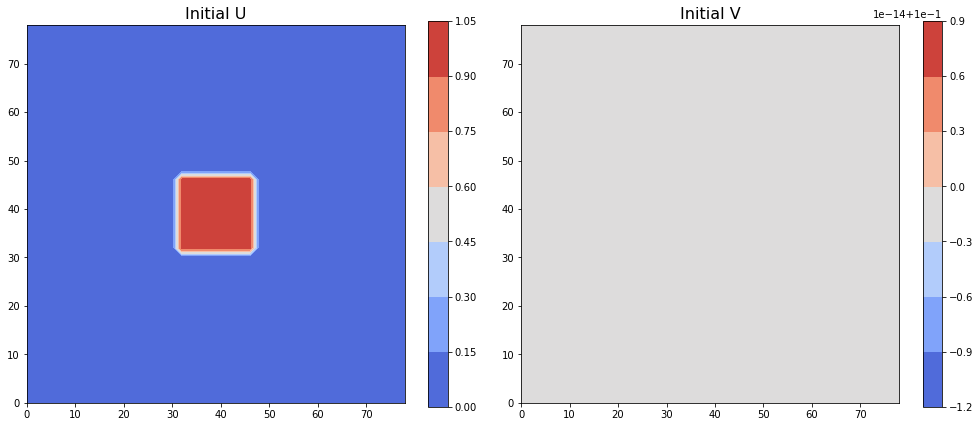

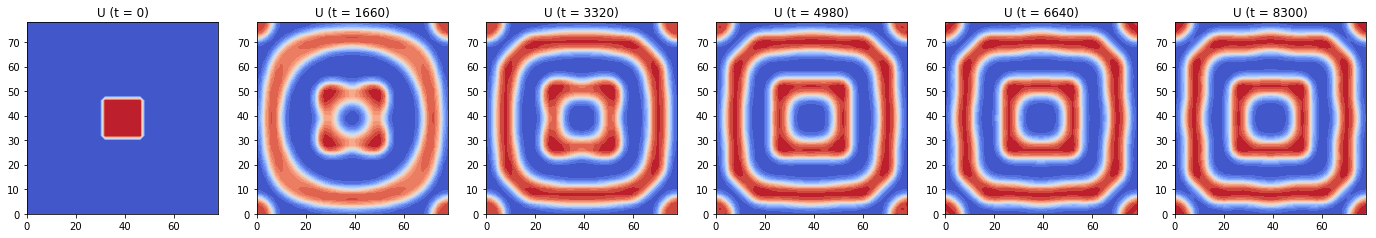

In [4]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Visualize initial conditions --- U: a centered cluster of ones
U_init = np.zeros((Ny, Nx)) 
j_0 = int(2/5*Ny) 
j_1 = int(3/5*Ny)
k_0 = int(2/5*Nx)
k_1 = int(3/5*Nx)
U_init[j_0:j_1, k_0:k_1] = 1
V_init = 0.1 * np.ones((Ny, Nx))
plot_init(U_init, V_init, h, filled=True)

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
        + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
        + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)

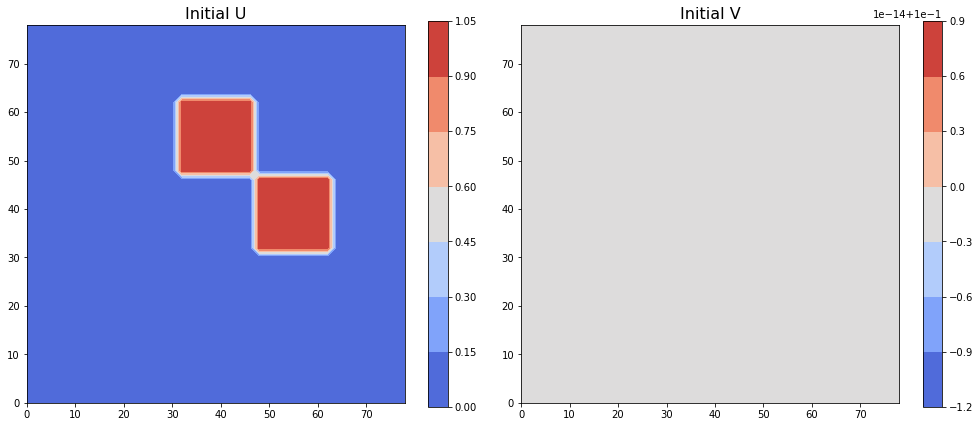

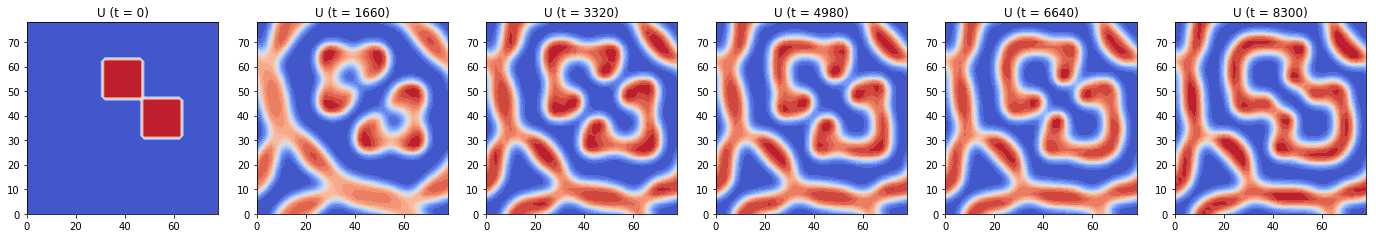

In [5]:
# Grid setup
Ny, Nx = 40, 40
h = 2
N = Nx * Ny

# Parameters setup
Du = 0.02
Dv = 2
rho = 0.001
rho_u = 0.001
mu_u = 0.02
mu_v = 0.03
kappa = 0.1

# Time steps
dt = 20
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

# Construct transform matrices
D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

# Factorize matrices
solve_Tu_x = linalg.factorized(Tu_x.tocsc())
solve_Tu_y = linalg.factorized(Tu_y.tocsc())
solve_Tv_x = linalg.factorized(Tv_x.tocsc())
solve_Tv_y = linalg.factorized(Tv_y.tocsc())

# Visualize initial conditions --- U: 2 clusters of ones
U_init = np.zeros((Ny, Nx)) 
ja_0 = int(2/5*Ny) 
ja_1 = int(3/5*Ny)
ka_0 = int(3/5*Nx)
ka_1 = int(4/5*Nx)
jb_0 = int(3/5*Ny) 
jb_1 = int(4/5*Ny)
kb_0 = int(2/5*Nx)
kb_1 = int(3/5*Nx)
U_init[ja_0:ja_1, ka_0:ka_1] = 1
U_init[jb_0:jb_1, kb_0:kb_1] = 1
V_init = 0.1 * np.ones((Ny, Nx))
plot_init(U_init, V_init, h, filled=True)

U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0] = np.copy(U_init)
V[0] = np.copy(V_init)

# Generate pattern
for i in range(1, time_steps):
    
    # Stage one - solve along x direction
    b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) + 0.5 * dt * rho/V[i - 1] * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) \
        + (1 - 0.5 * dt * mu_u) * U[i - 1] + 0.5 * dt * rho_u
    b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
        + 0.5 * dt * rho * U[i - 1]**2 / (1 + kappa*U[i - 1]**2) + (1 - 0.5 * dt * mu_v) * V[i - 1]

    U_middle = solve_Tu_x(b1U.T)
    V_middle = solve_Tv_x(b1V.T)

    # Stage two - solve along y direction
    b2U = 0.5 * Du * c * D2x.dot(U_middle) + 0.5 * dt * rho/V_middle * U_middle**2 / (1 + kappa*U_middle**2) \
        + (1 - 0.5 * dt * mu_u) * U_middle + 0.5 * dt * rho_u
    b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
        + 0.5 * dt * rho * U_middle**2 / (1 + kappa*U_middle**2) + (1 - 0.5 * dt * mu_v) * V_middle

    U[i] = solve_Tu_y(b2U.T)
    V[i] = solve_Tv_y(b2V.T)

plot_pattern_evolution(U, h, dt, time_steps, name='U', r=1, Nout=6)

## Summary
As visualized above, different initial conditions will generate different patterns. On the square domain, the initial condition of random numbers will generate **random spots or stripes**, while the initial condition of clusters of ones will become complicated patterns but they **preserved the symmetry of the initial conditions**:

- the random normal numbers formed a combination of random spots and stripes
- the centered clusters of 1's formed a set of square boundaries with different side lengths and the same symmetry of the initial cluster
- the 2 clusters of 1's formed an irregular pattern with the same symmetry of the initial 2 clusters